# An hands-on introduction to Convolutional Neural Networks
*Riccardo De Feo, riccardo.defeo@uef.fi*, [KUBIAC](https://blogs.uef.fi/kubiac/)
![](logos.png)
## What is a CNN?
According to Wikipedia, image analysis is the extraction of meaningful information from images. We can think of many image analysis techniques as functions, relating the image itself to the meaningful information we are interested in. 

Convolutional Neural Networks (from here on CNNs) are a family of algorithms that allow us to estimate a function mapping an image to the desired information, without necessarily knowing the details of that process. For example, we can build a CNN to map every pixel in a photo to a label indicating pedestrians, trees, cars, traffic lights and so on:

<img src="semantic_segmentation.jpg" alt="Segmentation sample from DeepLab" title="Segmentation sample from DeepLab" />

*Segmentation [sample](https://sthalles.github.io/deep_segmentation_network/) from [DeepLab](https://arxiv.org/pdf/1606.00915.pdf).*

The black-box nature of these systems can be at the same time an advantage and a disadvantage. Compared to other image processing techniques, we may not know exactly what the network is looking for to decide whether a certain shape corresponds to a tree or to a pedestrian. However, this also means that the CNN can potentially find the best features to reach this prediction without any need for us to explicitly formalize the difference between the picture of a tree and that of a person, which is no trivial task.

### Fully connected networks

Before jumping into CNNs let's spend a few words on the basic idea of Deep Neural Networks (DNNs). The structure is very simple, and it's based on a construction block called the perceptron:

<img src="perc.jpg">

*Image source [here](https://towardsdatascience.com/multi-layer-neural-networks-with-sigmoid-function-deep-learning-for-rookies-2-bf464f09eb7f)*

For each value (or **feature**) it takes as an input, we simply multiply it by a number, called the **weight**. We add up all of these products and include a bias term, specific for each perceptron. This is later fed to a nonlinear function (more on that later) and its output constitutes the output of the perceptron. To build what is called a **fully connected** layer in a deep neural network, we simply stack many perceptrons one next to the other. In the following image, each blue circle corresponds to a different perceptron unit:

<img src="DNN1.png">

Finally, to build a deep neural network, we stack one layer on top of the other, so that the outputs of one will become the inputs to the next:

<img src="DNN.png">

*Image source [here](https://deeplizard.com/learn/video/FK77zZxaBoI)*

Unlike a fully connected neural network, in a CNN each neuron (or filter) is only looking at a group of pixels located next to each other in the input image. In the next sections we will see indetail how that works.

### Implementation: PyTorch
It is not convenient to directly implement neural networks from scratch, and CNNs are no exception. Several effective frameworks are available for efficiently building this system, and during the course of this tutorial we will work with PyTorch.

With the following code we can import the PyTorch library and numpy, the fundamental package for scientific computing with Python. We will also need matplotlib, to display our results. With these tools, we can move forward and take a look at the basic concepts of CNNs.


In [1]:
import torchvision, torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

## How do they work?
The fundamental element of CNNs is the operation of convolution. To understand the general idea, let's look at a classic edge detection method: the Sobel operator.

How can we effectively detect edges like the one displayed in this 3x3 image?

<img src="edge1.png" alt="A vertical edge" title="A vertical edge" />

We can perform an element-by-element multiplication with the $S_x$ matrix, defined in the following way, and add up the results.

$$\mathbf{S}_{x}=\left[\begin{array}{ccc}
+1 & 0 & -1\\
+2 & 0 & -2\\
+1 & 0 & -1
\end{array}\right]$$

In our case, we are left with **1\*(-1) + 1\*(-2) + 1\*(-1) = -4**. If we repeated the same procedure multiplying this **Sobel filter** for a uniform image like the one below,  we would obtain a result of 0.

<img src="edge2.png" alt="A uniform image" title="A uniform image" />

The larger the variation in the horizontal direction, the further away we get from 0. In this way we can estimate the horizontal intensity gradient in the original image.

Now that we can detect whether we have an edge in a small area, we can use this to find edges in an arbitrarily large picture. We will simply do so by moving the filter over the larger image until we have covered its entire area. With the results of this operation we build a new image, in the following way:

<img src="convolve.gif" />

*Image source [here](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)*

We refer to this operation as a convolution. The size of the step we take each time we move the filter (1 in the animation above) is called the *stride*. As you can see, the output image is smaller than the original, even with a stride of 1, because we only get one element for each 3x3 element in the original. To compensate for this, we can simply expand the input image, using zeros or the values on the border. This operation is called padding:

<img src="padded.gif" />

*Image source [here](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)*

### Sobel filters in pytorch

Let's see this filter operating on a natural image. Run the next cell to load and visualize the picture:

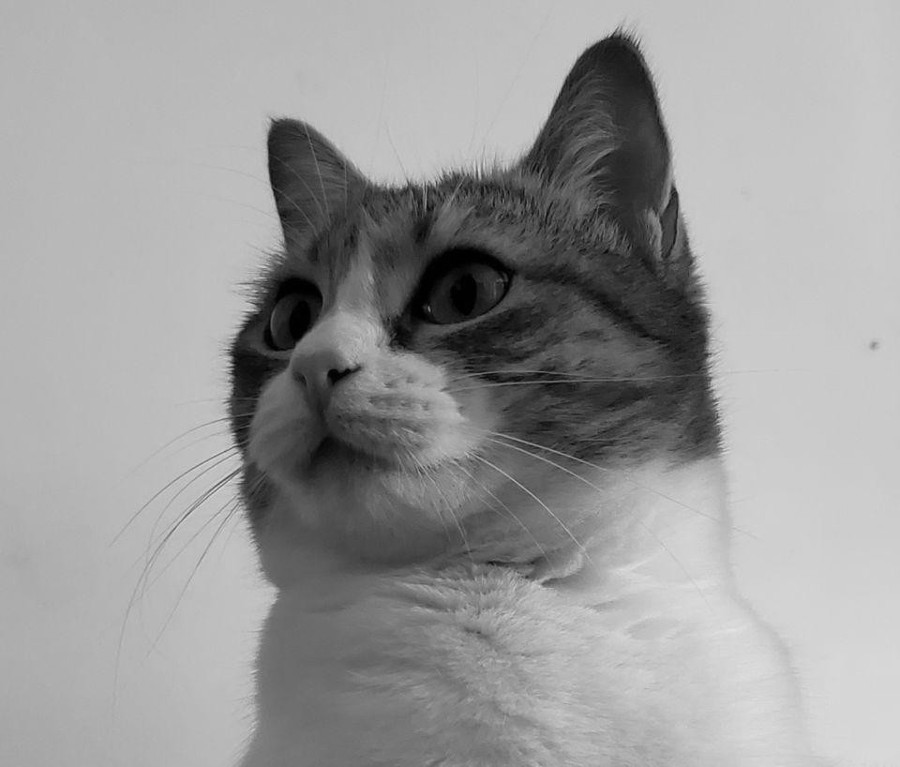

In [2]:
import PIL # to import photos
cat=PIL.Image.open('cat.jpg')
cat

We can now define Sobel filters in the two direction:

In [3]:
Sx=torch.tensor([[ 1,  0, -1],
                 [ 2,  0, -2],
                 [ 1,  0, -1]],
                requires_grad=False).type(torch.FloatTensor)

Sy=torch.tensor([[ 1,  2, 1],
                 [ 0,  0, 0],
                 [ -1,  -2, -1]],
                requires_grad=False).type(torch.FloatTensor)
print(Sx.shape,'\n')
print(Sy.shape)
Sx=Sx.reshape(1,1,3,3)
Sy=Sy.reshape(1,1,3,3)

torch.Size([3, 3]) 

torch.Size([3, 3])


And convolve these filters with the picture:

In [5]:
# PyTorch offers us utilities to easily transform images to tensors
# A tensor is simply a generalization of the idea of a matrix
# to an arbitrary number of dimensions

ToTensor=torchvision.transforms.ToTensor()
ToPIL=torchvision.transforms.ToPILImage()

# We can use ToTensor to generate a torch tensor
CAT=ToTensor(cat)
CAT=CAT.reshape([1]+list(CAT.shape))
CAT.shape


torch.Size([1, 1, 767, 900])

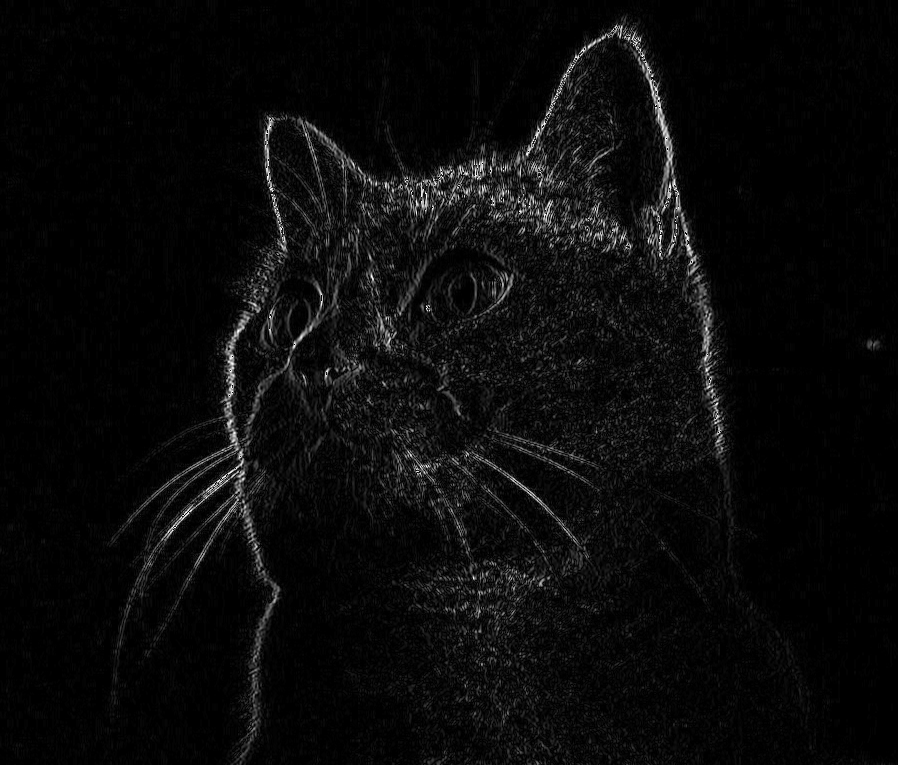

In [6]:
# And apply the convolution filter using conv2d
# Later we will look into the shape of these tensors in greater detail
# As we already have defined the filter, we can use
# nn.functional.conv2d to simply apply the convolution

Xconv=nn.functional.conv2d(CAT,Sx)
Xconv=Xconv.reshape(Xconv.shape[-3:])

# We are interested in edges, not the direction of the gradient. 
# So let's take the absolute value:
edges=ToPIL(torch.abs(Xconv))
edges

As you can see, we are focusing on vertical edges: this is because this filter only operates in one direction. Let's apply the Sobel filter for the perpendicular direction and visualize the output:

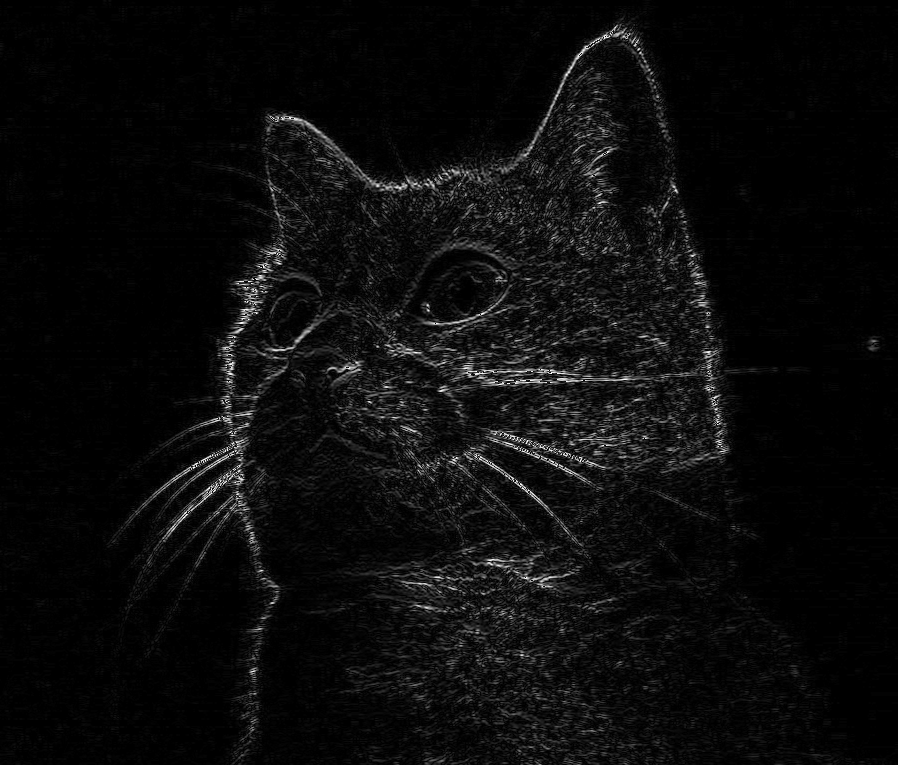

In [7]:
Yconv=nn.functional.conv2d(CAT,Sy)
Yconv=Yconv.reshape(Yconv.shape[-3:])
edges=ToPIL(torch.abs(Yconv))
edges

We can now see different details, and edges that were not present in the previous picture. Finally, we can combine both filters:

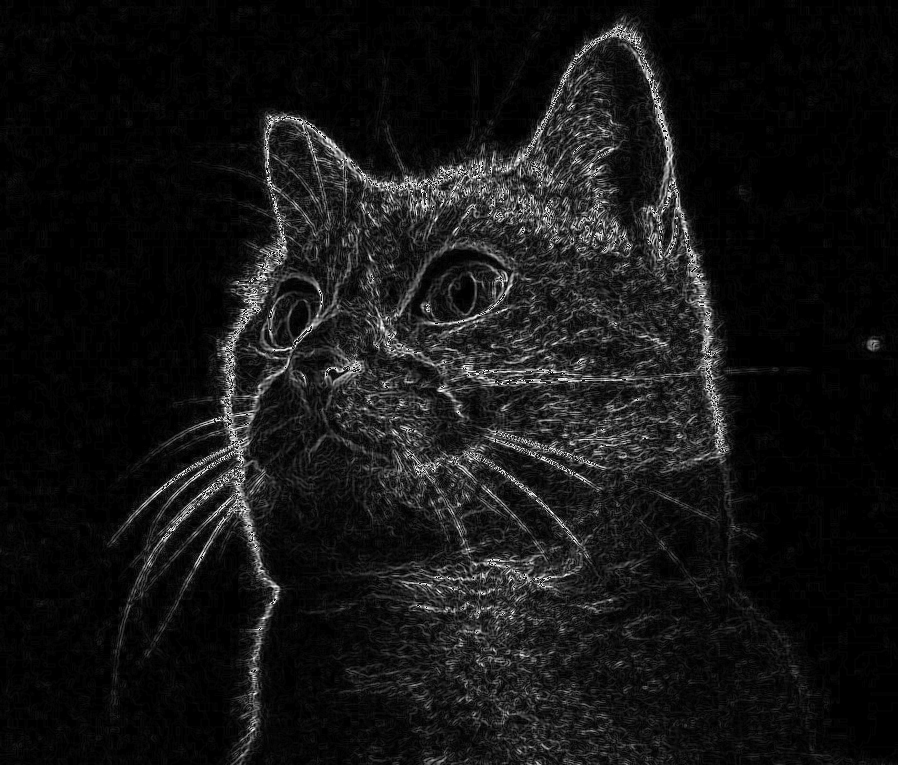

In [8]:
edges=ToPIL(torch.abs(Yconv)+torch.abs(Xconv))
edges

By combining these two filters we can draw edges in both directions.

In general, we do not know which filters we will need, how many, and how they should be combined. Can you imagine how a combination of similar filters might be used to decide whether this picture portrays a cat or a dog? This however would be a fairly reasonable task for a CNN.

### Convolutions in CNNs

The assumption behind CNNs is that we can extract the information we are interested in by stacking a number of convolutions, both in parallel and sequentially. The filters used in these convolutions will not be pre-determined: these will be initialized randomly and we will look for the optimal filters through a process of *optimization*.

As we just saw, we can extract more information by using more than one filter at the same time. A **convolutional layer** will apply a number of filters independently, and stack them one after the other:

<img src="channels.png"/>

*Drawn using [http://alexlenail.me/NN-SVG/LeNet.html](http://alexlenail.me/NN-SVG/LeNet.html)*

We stack these *feature maps* as *channels*, in the same way that a color image is defined by 3 channels: red, blue and green. As we proceed to the following convolutional layer, we want to combine the information extracted from different filters at the previous later. To do so, in general each filter on the new layer will operate on more than one input channel at the same time. In fact, unless otherwise specified, we assume that each filter is operating on all input channels.

This operation is not different from what we have already seen: the sum of an element-by-element product between input and filter. Each filter will present its distinct set of weights for each channel: a 3x3 filter operating on a 2-channel image will be represented by 2x3x3 = 18 elements, 3x3 for each channel.


## Pooling

Another typical element of CNNs is the pooling layer. The pooling layer is designed to down-sample its input, obtaining a lower-resolution representation. This helps us contain the computational cost and extract an high level abstraction, focusing on the most relevant features where high-resolution details could easily act as confounding factors or lead to overfitting: excessive specialization on the training data. More on that later.

Pooling also allows us to reach a large receptive field with a lower number of layers. The receptive field is the number of input pixels contributing to each output pixel. As illustrated in the picture below, without pooling layers we require a large number of convolution layers before reaching the same receptive field.

<img src="receptivefield.png"/>

*Source: [Han and Ye, 2017](https://arxiv.org/abs/1708.08333)*

Pooling layers can serve as architectural elements, allowing us to efficiently map feature maps to the output shape required.

### Common pooling strategies

<img src="pooling.png"/>

*Source [Yani et al. 2019](https://www.researchgate.net/figure/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max_fig2_333593451)*

#### Max pooling and average pooling

One of the most common strategies is max pooling. 2x2 max pooling means that for each 2x2 (usually non-overlapping) region of the input we select the maximum and build a new feature map out of these elements. A less common strategy is average pooling: rather than selecting the maximum, we simply take the average of the involved elements. While the stride of pooling operations is typically equal to the pooling size, ensuring the pooled areas do not overlap, this is not a general rule.

#### Strided convolution

As an alternative to max or average pooling, we can down-sample our feature maps by using a convolution operation with a stride greater than one. While this does not always result in improved performance, it allows us to include the pooling strategy in the optimization process.

## Activation functions

#### Rectified Liner Units:

Activation functions are a typical feature of neural networks in general. By adding non-linear functions, we can better approximate complicated, non-linear functions beween input and outputs. There are many activation functions in literature, but the most common is by far the Rectified Liner Unit (ReLU):

$$ \textrm{ReLU}(x)=\max(0,x) $$

ReLU simply leaves its input unchanged where positive, and return 0 for all negative inputs. This function is simply applied to every tensor element.

<img src="ReLU.png"/>

*Source: [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#relu)*

### Outputs

We often need different activation functions for our the last layers of our networks. 

#### Sigmoid

For a binary task, for example brain/background segmentation in medical imaging, we can use a function varying from 0 to 1. In this way we can represent the probability of belonging to the brain mask for each pixel. In this case, we can use the Sigmoid activation function:

$$ \textrm{Sigmoid}(x)= \frac{1}{1+\exp{(-x)}}$$

<img src="Sigmoid.png"/>

*Source: [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#relu)*

#### Softmax

Sometimes, however, we might need to decide between many, mutually exclusive categories. For example, when segmenting a urban scene, one pixel might be part of either a person, a car, or a tree. 

In this case, on the last layer we will output one different channel for each category. The softmax function will operate on all channels for each pixel separately:

$$ \textrm{Softmax}(x)=\frac{\exp{(x_i)}} {\sum_j\exp{x_j}} $$

This function approximates taking the maximum across different features with a continuous function. In the next section, we will see why this is important.

## Training

The parameters of the convolutional operations are initialized to random numbers. We need go through a process of optimization to approximate the function we are looking for. For this, first of all we need data, and we need to define what success means for us.

### Data

In this tutorial we are focusing on supervised CNNs: we assume we know what the correct solution is, and want to train a model that would reach the same correct conclusion given the same input. For this, we will need *labeled* data: a set of paired inputs and outputs. For a classification dataset, this will often mean one label for each image:

<img src="cifar.png"/>

*The [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset*

For a segmentation dataset, labels are defined on a pixel-by-pixel level:

<img src="munet.png"/>

*From [MU-Net](https://github.com/Hierakonpolis/MU-Net)*

The size of the dataset depends on the task we are interested in and its complexity. In literature we find work based on datasets going from millions of pictures to one or two segmented medical images. Segmentation tasks will often be more data-efficient than classification tasks. The general rule, however, is that more data is better. 

### Loss functions

We need to define a (differentiable) function to tell us how far we are to what we assume to be true. We can find many different loss functions in literature for different purposes. For now, let's go over two popular loss functions:

#### Cross-entropy

This function is defined for any number of mutually exclusive categories. Low values of this loss correspond to selecting the correct category with high certainty. For $N$ samples and $C$ categories, indicanting the true label for class $j$ and sample $i$ as $y_{i}^{j}$, and the predicted pseudo-probability of belonging to that class as $p_{i}^{j}$:

$$ -\frac{1}{N}\sum_{i}^{N}\sum_{j}^{C} y_{i}^{j} \log{(p_{i}^{j})} $$

$y_{i}^{j}=0$ for all categories except the correct one, in which case $y_{i}^{j}=1$, leaving for each sample only $ -\log{(p_true)} $. The closer we are to predicting 1 on the correct category, the lower this function will be.

#### Binary cross-etropy

For a two-categories task, we can use one single variable to represent the task, $y_i=1,0$. In this case this function assumes the form:

$$ \sum_{i}^{N} \left[ -y_i\log{p_i}-(1-y_i)\log(1-p_i)\right] $$

### Optimization

Once we defined our model, a loss function, and prepared our data, we can finally train the model. We want to look for the parameters that minimize our loss function. This is done through backpropagation:

1. Choose one or more data samples. This is called a **batch**. The number of data samples included is called the *batch size*.
2. **Forward propagation**: Feed the input through the CNN, performing all the operations as outlined above, and obtain the model's output.
3. Compute the **loss**.

<img src="gradient.png"> 

*A visualization of gradient descent in a 2D parameter space. Image source [here](https://medium.com/swlh/machine-learning-fundamentals-2-gradient-descent-algorithm-6c8f5204bd9b)*

4. **Backpropagation**: calculate the derivative of the loss function with respect to each parameter of the model, to find the gradient of the loss function in parameter space. This is performed through an iterative process starting from the parameters of the last layers and working our way back to the input layer using the chain rule of derivatives, hence the name backpropagation. We do not need to define this process explicitly: it will be handled by our framework.
5. **Gradient descent**: We modify the model parameters by taking a small step in the direction of the gradient, trying to minimize the loss function. The size of this step is controlled by a meta-parameter called the **learning rate**.
6. We iterate the same process over the entire dataset. This is called one **epoch**.
7. We keep iterating over the entire dataset, randomly changing the ordering of our samples, until **convergence**. 

We can increase the complexity of the optimization procedure to make it more robust. For example, we can choose a different learning rate for each parameter based on its statistics, or we can use each iteration to alter the gradient we used in the previous step rather than replace it entirely. One of the most popular optimizers, combining these strategies, is the Adam optimizer.

Typically, as we train the model the performance of our model on the training data will keep increasing throught the entire training process, but its performance on new data might start decreasing after a certain point, as the model becomes increasingly specialized on the training data.

### Validation

Using the same data to both train and test our model would be a mistake. We run the risk of **overfitting**: we might have a model that performs well on the training data, but fails to generalize to new data. Typically, we will need at least a *training set* and a *validation set*. By splitting the data in two different sets, we can:

1. Recognize overfitting
2. Compare different newtwork hyperparameters and architectures: from the learning rate to the number of convolutions and filters.
3. Use early stopping: stop the training when the accuracy on the validation set starts decreasing.

<img src="training.png"/>

We will always need at least a validation set, but preferably we will also need a *test set*. When we use the validation set to optimize different features of our model, we might be overfitting for the validation set. The model is only tested on the test set once, at the end of the entire training procedure, to evaluate its perspective real world performance.

The data distribution of the validation and test sets should hopefully be as close as possible to the distribution of the real world data we want to work with. Whether we will indeed use a separate test set depends on our data: when labeled data is scarce and costly, it might be preferable to only use two data sets to insure the training set remains large enough.

## Getting our hands dirty, with MNIST

Let's see these concepts at work with a well-known image analysis dataset: MNIST. MNIST is a set of hand-written digits from 0 to 9, and we hope to learn to recognize each digit with a convolutional neural network. Let's take a look at the data:

5


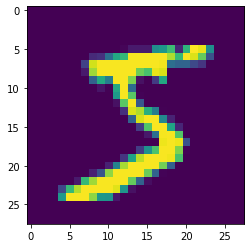

0


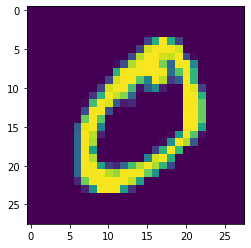

4


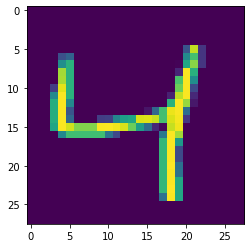

1


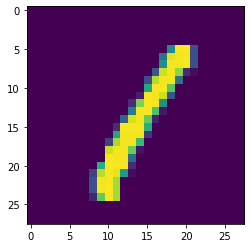

9


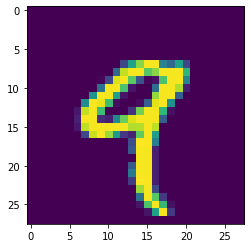

In [12]:
# PyTorch gives us an easy way to download and import these datasets:

MNIST=torchvision.datasets.MNIST('/tmp/MNIST',download=True,train=True) #Training set
Mtest=torchvision.datasets.MNIST('/tmp/MNIST',download=True,train=False) #Validation set

# MNIST is a list of pairs: one image and its ground truth value:

for k in range(5):
    print(MNIST[k][1]) # the label
    plt.imshow(MNIST[k][0]) # the image
    plt.show()

In [13]:
# Let's rebuild these torch dataset objects using a transformation to turn them into torch tensors:

tensorize=torchvision.transforms.ToTensor()
MNIST=torchvision.datasets.MNIST('/tmp/MNIST',download=True,train=True,transform=tensorize) #Training set
Mtest=torchvision.datasets.MNIST('/tmp/MNIST',download=True,train=False,transform=tensorize) #Validation set

# And let's look at the shape of these images:

MNIST[0][0].shape

torch.Size([1, 28, 28])

#### PyTorch conventions


Our data samples are 28x28 images. The typical PyTorch image will be a 3D tensor organized in this way: 

$$(Channels, Height, Width)$$

An RGB image would have 3 input channels, unlike our grayscale single-channel images. As we apply convolutions, the different outputs at the same layer will be stacked in the channel dimension. 3D volumes would be represented as:

$$(Channels,Depth, Height, Width)$$

We are about to add another index: the batch size. We will obtain tensors in the shape of:

$$(Batch,Channels, Height, Width)$$

In [14]:
# Let's choose a batch size of 10
Bsize=10

# By defining a dataloader object, we can easily iterate over a dataset object
# We will set a batch size, and shuffle the training set at each epoch

traindata=torch.utils.data.DataLoader(MNIST,batch_size=Bsize,shuffle=True)
testdata =torch.utils.data.DataLoader(Mtest,batch_size=Bsize,shuffle=False)


### Defining the model

Let's define the model. In PyTorch, we need to create a class for our model. When the class is instantiated (in the __init__ method) we will also instantiate each operation: convolutional layers, pooling layers, and activation functions. The __forward__ function will describe the operations we perform for each layer.

In [31]:
from torch import nn

class model(nn.Module):
    def __init__(self):
        super(model,self).__init__()
        
        # To define a convolution layer, we need at least:
        # 1. The number of input channels: 1
        # 2. The number of filters, or output channels. Let's choose 32
        # 3. The size of each filter. For a 3x3 filter it's enough to specify 3
        self.conv1=nn.Conv2d(3,32,3)
        
        # We can build a pooling layer by simply defining the pooling size,
        # by default the stride of pooling layers is equal to the size.
        # Let's build a 2x2 pooling layer:
        self.pool1=nn.MaxPool2d(2)
        
        # ReLU activation layers do not affect which element is the maximum for positive inputs.
        # For this reason it's computationally cheaper to apply our activation function
        # after the pooling layer, as there would be less elements to activate
        self.act1=nn.ReLU()
        
        # Let's repeat the same 3 layers. The image size will be halved again, and the number
        # of channels will double. This is again a common choice in CNNs
        self.conv2=nn.Conv2d(32,64,3)
        self.pool2=nn.MaxPool2d(2)
        self.act2=nn.ReLU()
        
        # We need to choose one between 10 classes. In our last layer, 
        # we can output 10 channels, one for each class
        self.conv3=nn.Conv2d(64,128,3)
        self.act3=nn.ReLU()
        
        self.conv4=nn.Conv2d(128,10,3)
    
    def forward(self,image):
        # We now define how each of the layers we created
        # comes into play. We can overwrite over the same tensor,
        # as we do not need to keep the intermediate feature maps.
        
        A=self.conv1(image)
        A=self.pool1(A)
        A=self.act1(A)
        A=self.conv2(A)
        A=self.pool2(A)
        A=self.act2(A)
        A=self.conv3(A)
        A=self.pool3(A)
        A=self.act3(A)
        A=self.conv4(A)
        # In the end we will need one prediction for each class. We can simply average
        # across all channels, to obtain a (batch, channels) tensor:
        #(batch, channel, w ,l )
        return torch.mean(A,dim=(2,3))

We will now instantiate the network, the loss function and the optimizer object. We will use the cross entropy loss. PyTorch's implementation of CE loss alredy contains a softmax activation on its input, so we do not need to apply that beforehand.

In [32]:
# Instantiating the model:

net=model()

# Loss function:
Loss=nn.modules.loss.CrossEntropyLoss()

# We will use the Adam optimizer. As we define it, we need to specify which
# parameters we are optimizing. We can refer to the parameters of our model
# by net.parameters(). Adam is an adaptive algorithm, we can choose an initial learning
# rate or 0.001

from torch.optim import Adam
optimizer=Adam(net.parameters(),lr=0.001)

Let's create a training loop over our data and see if this model works:

In [33]:
# We will train for just 2 epochs

epochs=10

import tqdm # To display a progress bar


for epoch in range(epochs):
    net.train() # set the network in training mode
    
    # For each batch we will take the samples, labels pairs:
    for sample, label in tqdm.tqdm(traindata,total=len(traindata)):
        # We need to manually zero the gradient
        optimizer.zero_grad()
        
        # Forward propagation
        predicted=net(sample)
        
        # calculate the loss function
        loss=Loss(predicted,label)
        
        # perform back propagation
        loss.backward()
        
        # one optimization step:
        optimizer.step()
    
    # set the network to evaluation mode
    # We will not calculate the gradient in this way, and perform inference faster
    net.eval() 
    with torch.no_grad():
        
        #we will now save the results in a list and get the accuracy:
        results=[]
        accuracylist=[]
        for sample, label in testdata:
            predicted=net(sample)
            results.append(Loss(predicted,label).mean().numpy())
            
            predictedvalues=torch.max(predicted,dim=1)[1]
            correct=predictedvalues==label
            accuracylist.append(correct.float().mean().numpy())
        print('\nloss:',np.mean(results))
        print('accuracy:',np.mean(accuracylist))
        

  0%|          | 0/1667 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [19]:
sample.shape

torch.Size([10, 1, 28, 28])

### An alternative approach

In the network we built above, we reduced the number of channels to 10 in the last layer, and took the channel wise average to build our classifier. An alternative approach would have been to replace the last convolution, the one that brought the number of channels to 10, with a dense neural network. To feed our features to a dense neural network, we simply need to take all of our feature maps and *flatten* them:

<img src="flatten.png">

*Image source [here](https://www.jeremyjordan.me/convolutional-neural-networks/)*

From here, we could have applied one or more fully-connected layers, and proceed in the same way to obtain 10 outputs for each data sample, and use them for classification. This approach presents one problem: while CNNs can easily deal with inputs of different sizes, as long as they are not part of the same batch, a dense neural network has a fixed number of weights, and it's built for inputs of a fixed size. While in this case it would not have made a difference, this approach would lose some of the flexibility of CNNs.


## Interpretation

Understanding exactly what a CNN is doing is far from straightforward, but we can try to look for which features activate a filter the most. From *[a classification network](https://kr.nvidia.com/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf)* trained on ImageNet, *[Zeiler and Fergus](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53)* generated the following pictures. As you can see, we start from simple features: trasitions of specific colors in specific direcitons, or patches of a certain color. As we move to the deeper layers, we find more complex shapes and pattern, until we have layers activated by the patterns specific to dogs or birds, and later on classify these images into these categories.

<img src="l1.png"/>
<img src="l2.png"/>
<img src="l3.png"/>

Interpreting the internal mechanics of a CNN remains, however, an active field of study.

## Practice

To practice what you just learned, feel free to reimplement a similar network for classification in the CIFAR10 dataset we briefly introduce above. This dataset is also available through pytorch. Spend some time familiarizing with it, provide the appropriate transformations, and test your classifier on the test set!

In [26]:
trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR', train=True,
                                        download=True, transform=tensorize)

testset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR', train=False,
                                       download=True, transform=tensorize)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

traindata=torch.utils.data.DataLoader(trainset,batch_size=30,shuffle=True)
testdata =torch.utils.data.DataLoader(testset,batch_size=30,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
trainset[15][1]

9